In [1]:
from simulations.elastic_collisions import Body, HiddenVariables, Variables, ElasticCollisionSimulation
import torch
from torch import Tensor
from torch.distributions import Distribution
from typing import Union, Callable

### The n-body collision problem

##### Visualise n body collision scenes for different bodies

#### Scenario 1 - Assumptions: 
- No force field (i.e. no air drag, attraction forces between bodies etc.)
- bodies are points of mass (a 'radius' value sets a range in which two close points are assumed to have collided)
- collisions are elastic (no loss of energy)
- the 'radius' values are the same and constant for each body
- the masses are the same and constant for each body 
- collisions with borders are also elastic
- the initial positions are fixed 

**Hidden variables:** initial velocity vectors

In [2]:

total_time = 10.0 
dt = 0.1
space_size = 10.0
max_radius = space_size // 10.0
acceleration_coefficient_value = 0.0
constant_mass_value = 1.0
constant_radius_value = max_radius
velocity_distribution = torch.distributions.Uniform(low=-5.0, high=5.0)
position_distribution = torch.distributions.Uniform(low=0.0, high=space_size)

num_bodies = 4
VARIABLES = Variables(
    masses = torch.full((num_bodies,), constant_mass_value),
    radii = torch.full((num_bodies,), constant_radius_value),
    starting_positions = None,
    initial_velocities= None,
    acceleration_coefficients = torch.full((num_bodies,), acceleration_coefficient_value),
    num_bodies = num_bodies,
    space_size = torch.tensor([space_size, space_size]),
)

initial_positions = ElasticCollisionSimulation.sample_initial_positions_without_overlap(VARIABLES, position_distribution)
VARIABLES.starting_positions = initial_positions
print(f"initial_positions: {initial_positions}")

initial_velocities = velocity_distribution.sample(sample_shape=torch.Size([num_bodies, 2]))
print(f"initial_velocities: {initial_velocities}")


simulation = ElasticCollisionSimulation( variables=VARIABLES, 
                                         enable_logging=False, 
                                         noise=False)

HIDDENVARIABLES = HiddenVariables(num_bodies=None, 
                                  masses=None,
                                  radii=None,
                                  acceleration_coefficients=None, 
                                  initial_velocities=initial_velocities,)

result = simulation.simulate(hidden_variables=HIDDENVARIABLES, \
                             total_time=total_time, \
                             dt=dt)

position_history = simulation.get_position_history()
velocity_history = simulation.get_velocity_history()

print(f"position_history: {position_history}")

# assume that position history is of length num_bodies 
assert len(position_history) == num_bodies
assert len(velocity_history) == num_bodies

# print position histories for body 1 
print(f"position_history for body 1: {position_history[0]}")
print(f"time history for body 1: {len(position_history[0])}")

# Transform the history so that each element represents a timestep
position_history_by_timestep = list(map(list, zip(*position_history)))
velocity_history_by_timestep = list(map(list, zip(*velocity_history)))

num_timesteps = len(position_history_by_timestep)

print(f"position_history_by_timestep: {position_history_by_timestep}")

# Assume that position history is of length num_timesteps
assert len(position_history_by_timestep) == num_timesteps
assert len(velocity_history_by_timestep) == num_timesteps

# Print position histories for timestep 1
print(f"position_history for timestep 1: {position_history_by_timestep[0]}")
print(f"velocity_history for timestep 1: {velocity_history_by_timestep[0]}")

print(f"position of body 1 at timestep 1: {position_history_by_timestep[0][0]}")
print(f"velocity of body 1 at timestep 1: {velocity_history_by_timestep[0][0]}")


initial_positions: tensor([[2.4354, 1.2880],
        [2.3205, 8.8614],
        [8.8774, 1.1443],
        [3.8727, 3.4638]])
initial_velocities: tensor([[ 0.7051, -1.2160],
        [ 4.9400,  2.7124],
        [ 3.0945,  0.8872],
        [ 3.4806,  4.0317]])
position_history: [[tensor([2.5059, 1.1664]), tensor([2.5765, 1.0448]), tensor([2.6470, 0.9232]), tensor([2.7175, 1.0448]), tensor([2.7880, 1.1664]), tensor([2.8585, 1.2880]), tensor([2.9290, 1.4096]), tensor([2.9995, 1.5312]), tensor([3.0700, 1.6528]), tensor([3.1405, 1.7744]), tensor([3.2110, 1.8960]), tensor([3.2815, 2.0176]), tensor([3.3520, 2.1392]), tensor([3.4225, 2.2608]), tensor([3.1102, 2.3548]), tensor([2.8003, 2.4490]), tensor([2.4905, 2.5432]), tensor([2.1806, 2.6373]), tensor([1.8708, 2.7315]), tensor([1.5610, 2.8257]), tensor([1.2511, 2.9199]), tensor([0.9413, 3.0140]), tensor([1.2511, 3.1082]), tensor([1.5610, 3.2024]), tensor([1.8708, 3.2966]), tensor([1.7905, 3.9007]), tensor([1.7114, 4.5032]), tensor([1.6323, 5.105

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def plot_timestep(ax, positions, velocities, space_size, max_radius):
    # Normalize the velocity vectors
    normalized_velocities = velocities / np.linalg.norm(velocities, axis=1, keepdims=True) * space_size

    # Set the limits of the plot
    ax.set_xlim([0, space_size])
    ax.set_ylim([0, space_size])

    # Set the aspect of the plot to be equal
    ax.set_aspect('equal')

    # Add a grid
    ax.grid(True)

    # Convert positions list to numpy array
    positions = np.array(positions)

    # Plot the positions of the bodies
    ax.scatter(positions[:, 0], positions[:, 1], color='b')

    # Add transparent circles at the location of each body
    for pos in positions:
        circle = patches.Circle((pos[0], pos[1]), radius=max_radius, alpha=0.5, edgecolor='none')
        ax.add_patch(circle)

    # Plot the normalized velocities as vectors and display the original velocity values
    for pos, vel, orig_vel in zip(positions, normalized_velocities, velocities):
        ax.quiver(pos[0], pos[1], vel[0], vel[1], color='r')
        ax.text(pos[0] + orig_vel[0]/2, pos[1] + orig_vel[1]/2, f'({orig_vel[0]:.2f}, {orig_vel[1]:.2f})', color='r', fontsize=40)

# Number of timesteps to plot
num_timesteps = 40

# Create a new figure with a grid of subplots
fig, axs = plt.subplots(8, 5, figsize=(80, 120))  # 5 rows, 8 columns

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Loop over the timesteps
for i in range(num_timesteps):
    # Get the positions and velocities for this timestep
    positions = position_history_by_timestep[i]
    velocities = velocity_history_by_timestep[i]

    # Plot this timestep
    plot_timestep(axs[i], positions, velocities, space_size, max_radius)
    axs[i].set_title(f'Timestep {i}', fontsize=46)


# Adjust the space between subplots to be minimal
#plt.subplots_adjust(wspace=0.01, hspace=0.1)
# Display the plot
plt.tight_layout()
plt.show()
    #

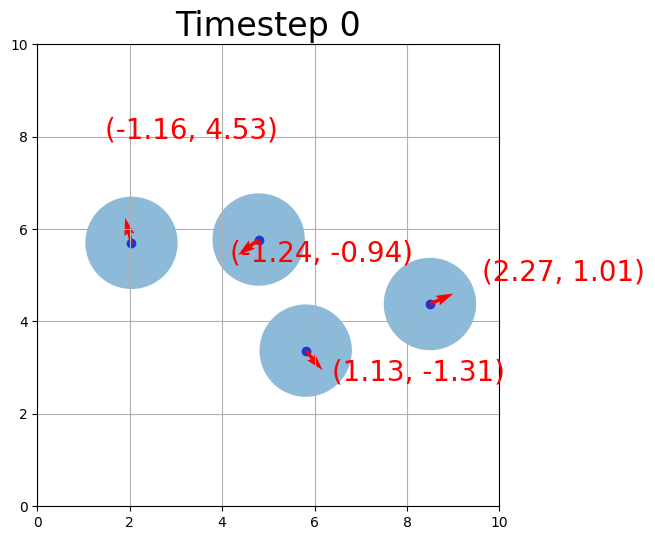

In [22]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
import numpy as np

def plot_timestep(i):
    ax.clear()
    positions = position_history_by_timestep[i]
    velocities = velocity_history_by_timestep[i]
    normalized_velocities = velocities / np.linalg.norm(velocities, axis=1, keepdims=True) * space_size

    ax.set_xlim([0, space_size])
    ax.set_ylim([0, space_size])
    ax.set_aspect('equal')
    ax.grid(True)

    positions = np.array(positions)
    ax.scatter(positions[:, 0], positions[:, 1], color='b')

    for pos in positions:
        circle = patches.Circle((pos[0], pos[1]), radius=max_radius, alpha=0.5, edgecolor='none')
        ax.add_patch(circle)

    for pos, vel, orig_vel in zip(positions, normalized_velocities, velocities):
        ax.quiver(pos[0], pos[1], vel[0], vel[1], color='r')
        ax.text(pos[0] + orig_vel[0]/2, pos[1] + orig_vel[1]/2, f'({orig_vel[0]:.2f}, {orig_vel[1]:.2f})', color='r', fontsize=20)

    ax.set_title(f'Timestep {i}', fontsize=24)

num_timesteps = 100
fig, ax = plt.subplots(figsize=(10, 6))

ani = animation.FuncAnimation(fig, plot_timestep, frames=num_timesteps, interval=200)
# Save the animation as a GIF
ani.save('animation.gif', writer=PillowWriter(fps=10))
